## Load Libraries and Firmware

In [300]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [301]:
# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2024-09-28_216_tprocv2r21_rfb_standard/qick_216_rfb.bit')
# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2025-06-15_216_tprocv2r24_standard/qick_216.bit')
soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/qick_tprocv2_216_standard_1ch_250822_1/qick_216.bit')

soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.362

Firmware configuration (built Fri Aug 22 10:35:19 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 2]

	1 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228 on JHC1, or QICK box DAC port 0

	1 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 4
		fs=2457.600 Msps, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		axis_avg_buffer v1.2 (has edge counter, no weights)
		memory 8192 accumulated, 4096 decimated (13.333 us)
		triggered by tport 10, pin 0, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226 on JHC7, or QICK box ADC port 4

	8 digital output pins:
	0:	PMOD0_0_LS
	1:	PMOD0_1_LS
	2:	PMOD0_2_LS
	3:	PMOD0_3_LS
	4

## basic multi-pulse program
Just a "reps" loop, no sweeping - like v1 AveragerProgram.

In v2, you define all of your pulses, and then you can play them as needed. Contrast to v1, where only one pulse could be defined on a generator at a time.

  0%|          | 0/10 [00:00<?, ?it/s]

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffde90c5750>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffde90c56c0>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffde90c56f0>, 'width': <qick.asm_v2.QickParam object at 0xfffde90c5720>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 9, 10})
	Pulse(ch=0, name='myflattop', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffde90ba230>}, t_regs={'t': 0})
	Pulse(ch=0, name='mygaus', t=0.4, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffde90ba290>}, t_regs={'t': 172})
	Pulse(ch=0, name='myconst', t=0.8, tag=None, t_params={'t': <qick.asm_v2.QickParam obj

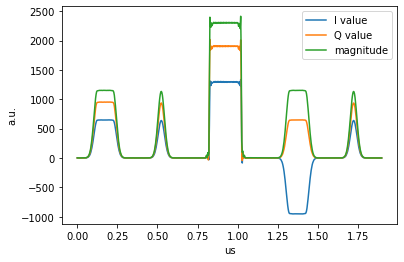

In [302]:
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 100
# FREQ = 0

class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

print(prog)
prog.print_pmem2hex()
prog.print_wmem2hex()
prog.print_sg_mem(sg_idx=0,gen_file=True)

## many envelopes pulses program

Test of several pulses generation using different envelope types (gauss, cosine, triangular, drag)


  0%|          | 0/1 [00:00<?, ?it/s]

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf2259c00>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf2259bd0>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf14af910>, 'width': <qick.asm_v2.QickParam object at 0xfffdf14afac0>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 9, 10})
	Pulse(ch=0, name='mygauss', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf14af9d0>}, t_regs={'t': 0})
	Pulse(ch=0, name='mycosine', t=0.2, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf14af880>}, t_regs={'t': 86})
	Pulse(ch=0, name='mytriangle', t=0.4, tag=None, t_params={'t': <qick.asm_v2.QickParam o

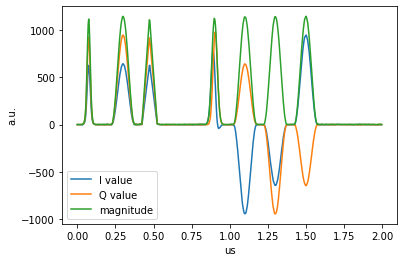

In [303]:
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 100

class ManyEnvelopesPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        gauss_len = 0.1
        self.add_gauss(ch=gen_ch, name="gauss", sigma=gauss_len/10, length=gauss_len, even_length=True)
        cosine_len = 0.15
        self.add_cosine(ch=gen_ch, name="cosine", length=cosine_len, even_length=True)
        triangle_len = 0.1
        self.add_triangle(ch=gen_ch, name="triangle", length=triangle_len, even_length=True)
        drag_len = 0.15
        self.add_DRAG(ch=gen_ch, name="drag", sigma=drag_len/10, delta=10, alpha=0.5, length=drag_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="mygauss", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="gauss", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mycosine", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="cosine", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mytriangle", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="triangle", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mydrag", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="drag", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mycosine90", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="cosine", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mycosine180", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="cosine", 
                       freq=cfg['freq'], 
                       phase=180,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mycosine270", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="cosine", 
                       freq=cfg['freq'], 
                       phase=-90,
                       gain=1.0, 
                      )



        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="mygauss", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mycosine", t=0.2)
        self.pulse(ch=cfg['gen_ch'], name="mytriangle", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="mydrag", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="mycosine90", t=1)
        self.pulse(ch=cfg['gen_ch'], name="mycosine180", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mycosine270", t=1.4)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 2.0,
         }

prog = ManyEnvelopesPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=1)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

print(prog)
prog.print_pmem2hex()
prog.print_wmem2hex()
prog.print_sg_mem(sg_idx=0,gen_file=True)

## tProc basic functionality
Write Data Registers

In [304]:
from qick.asm_v2 import QickProgramV2

prog = QickProgramV2(soccfg)
prog.declare_readout(ch=0, length=100)
prog.label('reg_wr_test')
# Write all the Data registers with some value
prog.write_reg(dst='r0',  src=12345678)
prog.write_reg(dst='r1',  src=12345678)
prog.write_reg(dst='r2',  src=12345678)
prog.write_reg(dst='r3',  src=12345678)
prog.write_reg(dst='r4',  src=12345678)
prog.write_reg(dst='r5',  src=12345678)
prog.write_reg(dst='r6',  src=12345678)
prog.write_reg(dst='r7',  src=12345678)
prog.wait(t=1)
prog.write_reg(dst='r8',  src=12345678)
prog.write_reg(dst='r9',  src=12345678)
prog.write_reg(dst='r10', src=12345678)
prog.write_reg(dst='r11', src=12345678)
prog.write_reg(dst='r12', src=12345678)
prog.write_reg(dst='r13', src=12345678)
prog.write_reg(dst='r14', src=12345678)
prog.write_reg(dst='r15', src=12345678)
# Write all the Data registers to 0
prog.wait(t=2)
prog.write_reg(dst='r0',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r1',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r2',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r3',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r4',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r5',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r6',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r7',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r8',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r9',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r10', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r11', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r12', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r13', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r14', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r15', src='s_zero')

prog.label('time_test')
prog.wait(t=3)
# Test the Dispatcher execution time
for N in range(11,31):
    prog.write_reg(dst='r15', src=N)
    prog.trigger(ros=[0], pins=[0], t=prog.cycles2us(2**N+15))

# Increase usr_time to test upper time bits
# Need to force internal register because tProc can't write it directly
# use an internal register to sync the testbench
# Wait for time to be 2**30
prog.wait(t=prog.cycles2us(2**30))
# Increase reference to 2**30
prog.delay(t=prog.cycles2us(2**30))

for N in range(31,49):
    prog.write_reg(dst='r15', src=N)
    # Force reference from testbench to be 2**N
    # prog.delay(t=prog.cycles2us(2**N))
    # Wait 1us
    prog.wait(t=1)
    # Push trigger after another 1us
    prog.trigger(ros=[0], pins=[0], t=1)
prog.end()


print(prog)
prog.print_pmem2hex()


Readout time 9 appears to conflict with previous readout ending at 104.796782?
Readout time 19 appears to conflict with previous readout ending at 109.558687?
Readout time 38 appears to conflict with previous readout ending at 119.082496?
Readout time 76 appears to conflict with previous readout ending at 138.130115?
Readout time 152 appears to conflict with previous readout ending at 176.225353?
Readout time 1 appears to conflict with previous readout ending at 100.034877?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previou

macros:
	Label(label='reg_wr_test')
	WriteReg(dst='r0', src=12345678)
	WriteReg(dst='r1', src=12345678)
	WriteReg(dst='r2', src=12345678)
	WriteReg(dst='r3', src=12345678)
	WriteReg(dst='r4', src=12345678)
	WriteReg(dst='r5', src=12345678)
	WriteReg(dst='r6', src=12345678)
	WriteReg(dst='r7', src=12345678)
	Wait(t=1, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf1513370>}, t_regs={'t': 430})
	WriteReg(dst='r8', src=12345678)
	WriteReg(dst='r9', src=12345678)
	WriteReg(dst='r10', src=12345678)
	WriteReg(dst='r11', src=12345678)
	WriteReg(dst='r12', src=12345678)
	WriteReg(dst='r13', src=12345678)
	WriteReg(dst='r14', src=12345678)
	WriteReg(dst='r15', src=12345678)
	Wait(t=2, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf1513310>}, t_regs={'t': 860})
	WriteReg(dst='r0', src='s_zero')
	Wait(t=0.1, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf1513430>}

## Test issue 359

In [305]:
from qick.asm_v2 import QickProgramV2, AsmInst

prog = QickProgramV2(soccfg)
prog.declare_readout(ch=0, length=100)
prog.label('arith_test')
prog.write_reg(dst='r0',  src=10)
prog.write_reg(dst='r1',  src=3)
# inst = AsmInst(inst={'CMD':"REG_WR", 'DST': 's2', 'SRC':'imm', 'LIT':'#49'}, addr_inc=1)
# prog.append_macro(inst)
# inst = AsmInst(inst={'CMD':"ARITH", 'C_OP': 'T', 'R1':'r0', 'R2':'r1'}, addr_inc=1)
# prog.append_macro(inst)
# inst = AsmInst(inst={'CMD': 'JUMP', 'IF': 'NF', 'ADDR': '&5'}, addr_inc=1)
# prog.append_macro(inst)
inst = AsmInst(inst={'CMD': 'PA', 'C_OP': '3', 'R1':'r0', 'R2':'r1'}, addr_inc=1)
prog.append_macro(inst)
prog.nop()
prog.nop()
prog.nop()
prog.nop()
prog.nop()
inst = AsmInst(inst={'CMD': 'PB', 'C_OP': '3', 'R1':'s6', 'R2':'r0', 'R3':'r1'}, addr_inc=1)
prog.append_macro(inst)
prog.nop()
prog.nop()
prog.nop()
prog.nop()
prog.nop()
prog.write_reg(dst='r2',  src=1234)
prog.write_reg(dst='r3',  src='s6')
prog.write_reg(dst='r4',  src='s7')

prog.end()

print(prog)

prog.print_pmem2hex()

macros:
	Label(label='arith_test')
	WriteReg(dst='r0', src=10)
	WriteReg(dst='r1', src=3)
	AsmInst(inst={'CMD': 'PA', 'C_OP': '3', 'R1': 'r0', 'R2': 'r1'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'PB', 'C_OP': '3', 'R1': 's6', 'R2': 'r0', 'R3': 'r1'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	WriteReg(dst='r2', src=1234)
	WriteReg(dst='r3', src='s6')
	WriteReg(dst='r4', src='s7')
	End()
registers:
pulses:
expanded ASM:
	arith_test:
	     NOP 
	arith_test:
	     REG_WR r0 imm #10 
	     REG_WR r1 imm #3 
	     PA 3 r0 r1 
	     NOP 
	     NOP 
	     NOP 
	     NOP 
	     NOP 
	     PB 3 s6 r0 r1 
	     NOP 
	

## Test issue 361

  0%|          | 0/1 [00:00<?, ?it/s]

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf1415600>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf14155d0>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Delay(t=1.0, auto=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf14155a0>}, t_regs={'t': 430})
	Pulse(ch=0, name='mypulse', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf140dd80>}, t_regs={'t': 0})
	Trigger(ros=[0], pins=[0], t=0.44, width=0.023251488095238096, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf14154e0>, 'width': <qick.asm_v2.QickParam object at 0xfffdf140cca0>}, t_regs={'t': 189, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 9, 10})
	Wait(t=0, auto=True, gens=False, ros=True, tag=None, no_warn=True, t_params={'t': <qick.asm_v2.Q

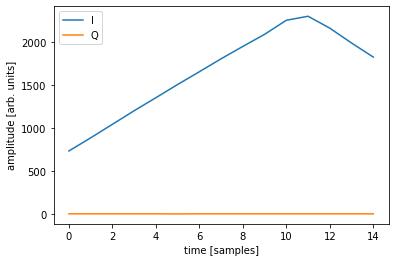

In [306]:
class RampProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=1)
            
        self.add_triangle(gen_ch, "myenv", cfg['pulse_len'])
        self.add_pulse(ch=gen_ch,
                      name="mypulse",
                      ro_ch=ro_ch,
                      style="arb",
                      freq=cfg['freq'],
                      envelope="myenv",
                      phase=cfg['phase'],
                      gain=cfg['gain'],
                      )

        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch,
                              name="myro",
                              freq=cfg['freq'],
                              gen_ch=gen_ch)

        self.send_readoutconfig(ch=ro_ch,
                                   name="myro",
                                   t=0)

    def _body(self, cfg):
        self.delay(1.0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        
config = \
{
    'gen_ch': 0,
    'ro_ch': 0,
    'freq': 0,
    'trig_time': 0.44,
    'ro_len': 0.05,
    'pulse_len': 0.1,
    'gain': 1.0,
    'phase': 0.0
}

prog = RampProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

# Test the decimated buffer
iq_list = prog.acquire_decimated(soc)
plt.plot(iq_list[0][:,0], label='I')
plt.plot(iq_list[0][:,1], label='Q')
plt.xlabel('time [samples]')
plt.ylabel('amplitude [arb. units]')
plt.legend()

# print(iq_list[:10])

print(prog)
prog.print_pmem2hex()
prog.print_wmem2hex()
# prog.print_sg_mem(sg_idx=0, gen_file=True)


In [307]:
# Start Debug Bridge Server if present
try:
    bridge = soc._get_block('debug_bridge_0')
    bridge.start_xvc_server(bufferLen=4096, serverAddress="0.0.0.0", serverPort=2542, reconnect=True, verbose=True)

except:
    print('Debug blocks not found')

XVC server started

In [308]:
## Do not forget to stop the XVC server once you finish.
bridge.stop_xvc_server()


XVC server stopped


# Qubit Emulator 
Frequency Sweep

In [309]:
class FrequencySweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch, outsel='product')

         # self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                    #    envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        # self.add_triangle(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        # self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
        #                style="arb", 
        #                envelope="ramp", 
        #                freq=cfg['freq'], 
        #                phase=cfg['phase'],
        #                gain=cfg['gain'], 
        #               )

        self.add_loop("freq_sweep", self.cfg["steps"])

    def _body(self, cfg):
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.1)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

[ 79.99999523  83.99997826  87.99996128  91.99994431  95.99992733
  99.99991035 103.99989338 107.9998764  111.99985943 115.99984245
 119.99982548]


  0%|          | 0/11 [00:00<?, ?it/s]

Text(0.5, 0, 'freq')

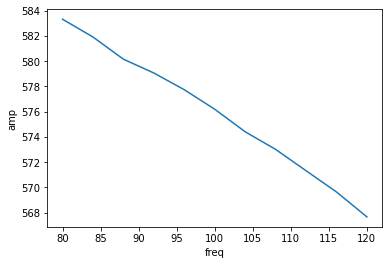

In [310]:
GEN_CH = 0
RO_CH = 0
FREQ = 100
DELTA_FREQ = 20

# do a sweep with STEPS points and plot decimated
config = {'steps': 11,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("freq_sweep", FREQ-DELTA_FREQ, FREQ+DELTA_FREQ),
          'trig_time': 0.5,
          'ro_len': 2.0,
          'flat_len': 1.0,
          'ramp_len': 0.1,
          'phase': 0,
          'gain': 0.5
         }

# prog = FrequencySweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
# iq_list = prog.acquire_decimated(soc, rounds=1)

# plt.figure()
# t = prog.get_time_axis(ro_index=0)
# for ii, iq in enumerate(iq_list[0]):
#     # plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
#     plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
# plt.legend()
# plt.ylabel("a.u.")
# plt.xlabel("us")


prog = FrequencySweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
print(freqs)
iq_list = prog.acquire(soc, rounds=1, progress=True)

plt.figure()
plt.plot(freqs, np.abs(iq_list[0][0].dot([1,1j])))
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
# plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("amp")
plt.xlabel("freq")



In [311]:
print(prog)
prog.print_pmem2hex()
prog.print_wmem2hex()
prog.print_sg_mem(sg_idx=0,gen_file=True)

macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf0d9beb0>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	OpenLoop(n=11, name='freq_sweep')
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf0d9be50>}, t_regs={'t': 0})
	Pulse(ch=0, name='mypulse', t=0.1, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf0d9be20>}, t_regs={'t': 43})
	Trigger(ros=[0], pins=[0], t=0.5, width=0.023251488095238096, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf0d9b580>, 'width': <qick.asm_v2.QickParam object at 0xfffdf0d9b640>}, t_regs={'t': 215, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 10})
	Wait(t=0, auto=True, gens=False, ros=True, tag=None, no_warn=True, t_params={'t': <qick.asm_v2.QickParam object at 0xfffdf225a020>}, t_regs={'t': 1075})
	Delay(t=0.5, auto=True, gens